Used CIFAR100 dataset to train my model with 0 as class for inverted image and 1 for upright image.

Rotated all the images in the database and trained the model.
It classified every image as inverted in the given dataset thus 100%accuracy but prob were not high so the model didn't work.

Maybe bitwise XOR model would work or fourier transform of the images.





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import cv2
import tensorflow as tf
import keras
import numpy as np
import os
import sys
from PIL import Image 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.utils import shuffle
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [88]:
#load train and test dataset
(trainX,_),(testX,_)=tf.keras.datasets.cifar100.load_data(label_mode="fine")
print('Train: {0}'.format(trainX.shape))
print('Test: {0}'.format(testX.shape))

Train: (50000, 32, 32, 3)
Test: (10000, 32, 32, 3)


In [0]:
#creating labels: 0 for inverted, 1 for upright 
trainY=np.full((50000,1),1)
testY=np.full((10000,1),1)
rot_trainY=np.full((50000,1),0)
rot_testY=np.full((10000,1),0)
#bigger dataset
TrainY=np.concatenate((trainY,rot_trainY),axis=0)
TestY=np.concatenate((testY,rot_testY),axis=0)


In [0]:
#scale pixels
trainX=trainX.astype('float32')
testX=testX.astype('float32')
trainX=trainX/255.0
testX=testX/255.0
testX=np.array(testX)
trainX=np.array(trainX)

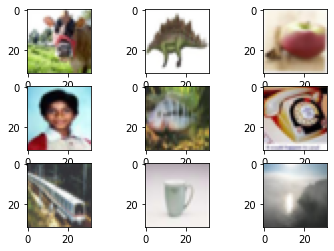

In [91]:
#some examples
for i in range(9):
  plt.subplot(330+1+i)
  plt.imshow(trainX[i])
plt.show()

In [0]:
#rotates image by 180
def rotate(img):
  rot_90=np.rot90(img)
  rot_180=np.rot90(rot_90)
  return rot_180

In [0]:
#rotating given dataset by 180 
rot_train,rot_test=[],[]
for i in range(50000):
  rot_train.append(rotate(trainX[i]))
for i in range(10000):
  rot_test.append(rotate(testX[i]))
rot_train=np.array(rot_train)
rot_test=np.array(rot_test)

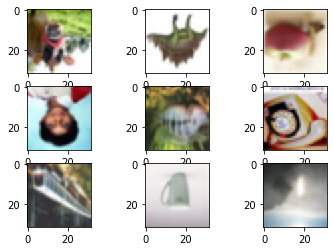

In [94]:
#some examples
for i in range(9):
  plt.subplot(330+1+i)
  plt.imshow(rot_train[i])
plt.show()

In [95]:

#shapes of rotated dataset
print('rotated Train: {0}'.format(rot_train.shape))
print('rotated Test: {0}'.format(rot_test.shape))
#shapes of original dataset
print('Train: {0}'.format(trainX.shape))
print('Test: {0}'.format(testX.shape))

rotated Train: (50000, 32, 32, 3)
rotated Test: (10000, 32, 32, 3)
Train: (50000, 32, 32, 3)
Test: (10000, 32, 32, 3)


In [96]:
#combining to form bigger dataset 
TrainX=np.concatenate((trainX,rot_train),axis=0)
TestX=np.concatenate((testX,rot_test),axis=0)
#shuffling the dataset with labels
TrainX,TrainY = shuffle(TrainX,TrainY)
TestX,TestY = shuffle(TestX,TestY)

#final shapes
print('TrainX: {0}'.format(TrainX.shape))
print('TestX: {0}'.format(TestX.shape))
print('TrainY: {0}'.format(TrainY.shape))
print('TestY: {0}'.format(TestY.shape))


TrainX: (100000, 32, 32, 3)
TestX: (20000, 32, 32, 3)
TrainY: (100000, 1)
TestY: (20000, 1)


In [0]:
#cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.5))
	model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.5))
	model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(256, activation='elu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.009, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [0]:
#create data generator
datagen=ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,vertical_flip=True)
model=define_model()
it=datagen.flow(TrainX,TrainY,batch_size=32)
steps=int(TrainX.shape[0]/32)
#training the model
history=model.fit_generator(it,steps_per_epoch=steps,epochs=40,validation_data=(TestX,TestY),verbose=0)



In [102]:
#print the accuracy on test set
_, acc = model.evaluate(TestX, TestY, verbose=0)
print('> %.3f' % (acc * 100.0))



> 51.265


In [113]:
#upload photos for testing
from google.colab import files
uploaded = files.upload()

Saving DSC_0070.JPG to DSC_0070.JPG
Saving inv.jpg to inv (1).jpg
Saving inv1.jpg to inv1 (1).jpg
Saving inv2.jpg to inv2 (1).jpg
Saving inv3(1).jpg to inv3(1) (1).jpg
Saving inv3.jpg to inv3 (1).jpg


In [0]:
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(32, 32))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 32, 32, 3)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img
 

In [118]:
#Predicting given images' class and rotating if they are inverted
imgs=[]
for key in uploaded.keys():
  imgs=load_image(key)    #load the image
  img_class=model.predict_classes(imgs)    #predict the prob
  print('{0} class: {1}'.format(key,img_class))  
  if img_class==[[0]]:  #rotating the image if inverted and saving in the directory
    r_img=rotate(imgs)
    cv2.imwrite('rotated_'+str(key),r_img)




DSC_0070.JPG class: [[0]]
inv.jpg class: [[0]]
inv1.jpg class: [[0]]
inv2.jpg class: [[0]]
inv3(1).jpg class: [[0]]
inv3.jpg class: [[0]]
